# Description of Project

I conduct a predictive modeling procedure, based on Random Forests machine learning, to find the most predictive model of my chosen outcome variable based on a set of economic data.

The data for the predictors comes from Richter and Lucas (2016)'s GSRE 1.0 - Global State Revenues and Expenditures Dataset, accessible [here](https://search.gesis.org/research_data/SDN-10.7802-1290). The data record state budget indicators for 161 countries between 1946 and 2006.

The data for the outcome variable comes from the Varieties of Democracy dataset v15, accessible [here](https://v-dem.net/data/the-v-dem-dataset/country-year-v-dem-fullothers-v15/). The data record hundreds of indicators of democracy, regime characteristics, and more. My specific outcome variable is their high-level "electoral democracy index", which they code as "v2x_polyarchy". In their codebook, this variable is described as follows:

"*Question*: To what extent is the ideal of electoral democracy in its fullest sense achieved?

*Clarification*: The electoral principle of democracy seeks to embody the core value of making rulers responsive to citizens, achieved through electoral competition for the electorate’s approval under circumstances when suffrage is extensive; political and civil society organizations can operate freely; elections are clean and not marred by fraud or systematic irregularities; and elections affect the composition of the chief executive of the country. In between elections, there is freedom of expression and an independent media capable of presenting alternative views on matters of political relevance. In the V-Dem conceptual scheme, electoral democracy is understood as an essential element of any other conception of representative democracy — liberal, participatory, deliberative, egalitarian, or some other.

*Scale*: Interval, from low to high (0-1)."

I use Random Forests, combined with other procedures, to find the combination of GSRE variables most predictive of v2x_polyarchy in the year 2005. I evaluate this model's out-of-sample performance using cross-validation.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


#1. Data Importing and Cleaning
## 1.1 Cleaning V-Dem Data

I'll start by cleaning the V-Dem data to get my dependent variable: v2x_polyarchy (the Electoral Democracy Index).

In [5]:
# import data
vdem_raw = pd.read_csv("/Users/timmyobrien/Desktop/Python Code Sample/data/V-Dem-CY-Full+Others-v15.csv")

/var/folders/gk/gw75vw5n0632256xqtq7bkn40000gn/T/ipykernel_14895/2836892602.py:2: DtypeWarning: Columns (364,365,366,399,804,836,837,924,1240,1257,1486,3094,3168,3169,3341,3342,3344,3345,3347,3350,3352) have mixed types. Specify dtype option on import or set low_memory=False.
  vdem_raw = pd.read_csv("/Users/timmyobrien/Desktop/Python Code Sample/data/V-Dem-CY-Full+Others-v15.csv")


In [6]:
# let's get a sense of the data
print(f"Dimensions: {vdem_raw.shape}")
print(f"Data types: {vdem_raw.dtypes.value_counts()}")

vdem_raw.head()

Dimensions: (27913, 4607)
Data types: float64    4560
object       29
int64        18
Name: count, dtype: int64


,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,...,e_mipopula,e_miurbani,e_pefeliex,e_wb_pop,e_pechmor,e_miinteco,e_civil_war,e_miinterc,e_pt_coup,e_pt_coup_attempts
0,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
1,Mexico,MEX,3,1790,1790-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2,Mexico,MEX,3,1791,1791-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,Mexico,MEX,3,1792,1792-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
4,Mexico,MEX,3,1793,1793-12-31,1,1,Viceroyalty of New Spain,1789,2024,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN


If things are correct, you should get:

Dimensions: (27644, 4607)

Data types:

float64    4567

object       29

int64        11

In [7]:
# focus only on 2005
vdem = vdem_raw[vdem_raw["year"] == 2005]

In [8]:
# check again
print(f"Dimensions: {vdem.shape}")
print(f"Data types: {vdem.dtypes.value_counts()}")

vdem.head()

Dimensions: (177, 4607)
Data types: float64    4560
object       29
int64        18
Name: count, dtype: int64


,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,...,e_mipopula,e_miurbani,e_pefeliex,e_wb_pop,e_pechmor,e_miinteco,e_civil_war,e_miinterc,e_pt_coup,e_pt_coup_attempts
216,Mexico,MEX,3,2005,2005-12-31,0,1,United Mexican States,1789,2024,...,NaN,NaN,NaN,105442402.0,20.53,NaN,0.0,NaN,0.0,0.0
341,Suriname,SUR,4,2005,2005-12-31,0,0,Republic of Suriname [independent state],1900,2024,...,NaN,NaN,NaN,516220.0,29.09,NaN,0.0,NaN,0.0,0.0
577,Sweden,SWE,5,2005,2005-12-31,0,1,Kingdom of Sweden,1789,2024,...,NaN,NaN,NaN,9029572.0,3.60,NaN,0.0,NaN,0.0,0.0
804,Switzerland,CHE,6,2005,2005-12-31,0,1,Swiss Confederation,1798,2024,...,NaN,NaN,NaN,7437115.0,5.07,NaN,0.0,NaN,0.0,0.0
927,Ghana,GHA,7,2005,2005-12-31,0,0,Republic of Ghana,1902,2024,...,NaN,NaN,NaN,22496951.0,84.15,NaN,0.0,NaN,0.0,0.0


The number of rows seems correct - roughly mirrors the number of countries/territories in the world.

I need to check if my dependent variable, v2x_polyarchy, take any NaN/NA values. If it does, I might need to impute values or drop observations.

In [9]:
# keep v2x_polyarchy because it is the DV
# keep COWcode so I can easily merge with the other dataset
vdem_small = vdem[["v2x_polyarchy", "COWcode"]]

In [10]:
print(sum(pd.isna(vdem_small["v2x_polyarchy"])))

0


Reassuringly, my DV does not take NaNs/NAs.

## 1.2 Cleaning Global State Revenues and Expenditures (GSRE) Data

Now, I'll clean the Global State Revenues and Expenditures (GSRE) data. The process will be nearly identical to that above.

In [12]:
# import data
gsre_raw = pd.read_csv("/Users/timmyobrien/Desktop/Python Code Sample/data/GSRE_extended_1_0.csv", encoding = "latin1", sep = None)

/var/folders/gk/gw75vw5n0632256xqtq7bkn40000gn/T/ipykernel_14895/28642298.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  gsre_raw = pd.read_csv("/Users/timmyobrien/Desktop/Python Code Sample/data/GSRE_extended_1_0.csv", encoding = "latin1", sep = None)


In [13]:
print(f"Dimensions: {gsre_raw.shape}")
print(f"Data types: {gsre_raw.dtypes.value_counts()}")

gsre_raw.head()

Dimensions: (7097, 440)
Data types: float64    428
object       8
int64        4
Name: count, dtype: int64


,year,cowname,cowcode,wbname,imfcode,country,id_GSRE,fiscal_year,member,currency,...,labor_force_WDIpc,foreign_labor_force_WDIpc,national_labor_force_WDIpc,total_public_employment_WDIpc,foreign_public_employment_WDIpc,national_public_employment_WDIpc,government_pubemploy_WDIpc,government_employ_WDIpc,employment_in_defence_WDIpc,worldregion
0,1978,BHM,31,BHS,313,Bahamas,1,1978,1950,BahamianDollars,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
1,1979,BHM,31,BHS,313,Bahamas,1,1979,1950,BahamianDollars,...,0.383424,NaN,NaN,0.063095,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
2,1980,BHM,31,BHS,313,Bahamas,1,1980,1950,BahamianDollars,...,NaN,NaN,NaN,0.057154,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
3,1981,BHM,31,BHS,313,Bahamas,1,1981,1950,BahamianDollars,...,NaN,NaN,NaN,0.059005,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
4,1982,BHM,31,BHS,313,Bahamas,1,1982,1950,BahamianDollars,...,NaN,NaN,NaN,0.062604,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean


In [14]:
gsre = gsre_raw[gsre_raw["year"] == 2005]

In [15]:
# check again
print(f"Dimensions: {gsre.shape}")
print(f"Data types: {gsre.dtypes.value_counts()}")

gsre.head()

Dimensions: (156, 440)
Data types: float64    428
object       8
int64        4
Name: count, dtype: int64


,year,cowname,cowcode,wbname,imfcode,country,id_GSRE,fiscal_year,member,currency,...,labor_force_WDIpc,foreign_labor_force_WDIpc,national_labor_force_WDIpc,total_public_employment_WDIpc,foreign_public_employment_WDIpc,national_public_employment_WDIpc,government_pubemploy_WDIpc,government_employ_WDIpc,employment_in_defence_WDIpc,worldregion
27,2005,BHM,31,BHS,313,Bahamas,1,2005,1950,BahamianDollars,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
88,2005,CUB,40,CUB,928,Cuba,2,NaN,1946-2023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
149,2005,HAI,41,HTI,263,Haiti,3,2004/2005,1953,Gourdes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
210,2005,DOM,42,DOM,243,Dominican Republic,4,NaN,1945,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
255,2005,JAM,51,JAM,343,Jamaica,5,NaN,1963,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean


156 countries in 2005, a fairly reasonable number. Things seem correct.

## 1.3 Merging and Final Cleaning

Now, I'll merge the V-Dem dataset with the GSRE dataset. Then, I'll clean up any last unnecessary columns.

In [16]:
df_merged = vdem_small.merge(gsre, how = "left", left_on = "COWcode",
                             right_on = "cowcode")

In [17]:
print(f"Dimensions: {df_merged.shape}")
print(f"Data types: {df_merged.dtypes.value_counts()}")
df_merged.head()

Dimensions: (177, 442)
Data types: float64    434
object       8
Name: count, dtype: int64


,v2x_polyarchy,COWcode,year,cowname,cowcode,wbname,imfcode,country,id_GSRE,fiscal_year,...,labor_force_WDIpc,foreign_labor_force_WDIpc,national_labor_force_WDIpc,total_public_employment_WDIpc,foreign_public_employment_WDIpc,national_public_employment_WDIpc,government_pubemploy_WDIpc,government_employ_WDIpc,employment_in_defence_WDIpc,worldregion
0,0.710,70.0,2005.0,MEX,70.0,MEX,273.0,Mexico,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
1,0.776,115.0,2005.0,SUR,115.0,SUR,366.0,Suriname,22.0,2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean
2,0.909,380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.888,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.736,452.0,2005.0,GHA,452.0,GHA,652.0,Ghana,72.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa


Dimensions and head look good. I need to clean up these excess columns from the merge, as well as deal with the object variables.

In [18]:
object_cols = df_merged.select_dtypes(include = ["object"]).columns

print(f"Object: {object_cols.tolist()}")

Object: ['cowname', 'wbname', 'country', 'fiscal_year', 'member', 'currency', 'source', 'worldregion']


The object variables all appear to be meta/identification variables or irrelevant variables (e.g. "cowname", "wbname", etc.). Therefore, we can safely drop them as they are unlikely to be predictive for our purposes.

In [19]:
df_merged = df_merged.drop(columns = list(object_cols))

In [20]:
df_merged.head()

,v2x_polyarchy,COWcode,year,cowcode,imfcode,id_GSRE,current_GDP,total_balance,total_revenues,total_expenditures,...,owelfarespend_GDPWDI_WDIpc,labor_force_WDIpc,foreign_labor_force_WDIpc,national_labor_force_WDIpc,total_public_employment_WDIpc,foreign_public_employment_WDIpc,national_public_employment_WDIpc,government_pubemploy_WDIpc,government_employ_WDIpc,employment_in_defence_WDIpc
0,0.710,70.0,2005.0,70.0,273.0,11.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.776,115.0,2005.0,115.0,366.0,22.0,4.856000e+09,-185700000.0,1.271000e+09,1.457000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.909,380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.888,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.736,452.0,2005.0,452.0,652.0,72.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Still some uninformative columns to drop (e.g. "codingstart_contemp", "gapstart1", etc.) that I should drop.

In [21]:
df_clean = df_merged.drop(columns = ["COWcode", "year", "cowcode", "imfcode",
                              "id_GSRE"])

In [22]:
# examine the data after cleaning to make sure everything looks okay
print(f"Dimensions: {df_clean.shape}")
print(f"Data types: {df_clean.dtypes.value_counts()}")

Dimensions: (177, 429)
Data types: float64    429
Name: count, dtype: int64


This all looks reasonable. The variables are all numeric (float64), which we need for Random Forests regression to work properly. The dimensions of the dataset match expectations.

Let's now figure out which of these GSRE variables is most predictive of my chosen Y variable, "v2x_polyarchy", which is V-Dem's electoral democracy index. v2x_polyarchy is measured on an interval scale from 0-1, with 1 representing perfect electoral democracy and 0 representing a complete lack of electoral democracy.

In [23]:
# X = all variables in the dataframe except v2x_polyarchy, y = v2x_polyarchy
X = df_clean.drop(columns=["v2x_polyarchy"])
y = df_clean["v2x_polyarchy"]

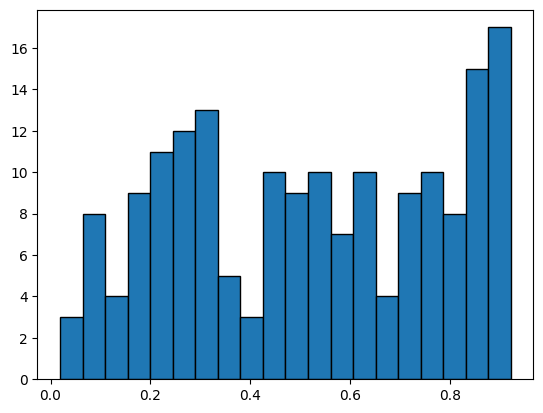

In [24]:
# might be useful to know if my DV has outliers if I want to address later
plt.hist(y, bins = 20, edgecolor = "black");

Seems fine, no serious outliers.

# 2. Random Forests

To find the most important variables, I run Random Forests (abbreviated as "RF" hereafter) 50 times to get an array of variable importances - i.e. 50 arrays ranking the variables based on their predictiveness. This process took approximately 3 minutes on my system. If you prefer not to wait, you can load in "importances.npy" in the designated cell. I deal with overfitting later through cross-validation. My specification of "oob_score = True" also helps to estimate my model's generalizability.

## 2.2 Run Random Forests on Training Data

In [25]:
importances = []

In [26]:
# SKIP IF YOU DO NOT WANT TO WAIT, LOAD BELOW

# 50 runs - should be enough for reliable results without waiting too long
for run in range(50):
  model = RandomForestRegressor(n_estimators = 100, random_state = run, oob_score = True)
  model.fit(X, y)
  importances.append(model.feature_importances_)

In [27]:
# if you skipped above, load in the importances.npy file
importances = np.load("importances.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'importances.npy'

In [28]:
importances = np.array(importances)

In [29]:
# check that this process worked
importances.shape


(50, 428)

Good, there are 50 runs and 428 variables (recall that there were 429 in df_clean, but 1 is v2x_polyarchy and thus was dropped). This matches with what we expect.

In [30]:
# calculate the mean and standard deviation of our importances array
importances_mean = importances.mean(axis = 0)
importances_sd = importances.std(axis = 0)

In [31]:
rf_vars = X.columns

rankings = pd.DataFrame({
    "variable": rf_vars,
    "mean importance": importances_mean
    }).sort_values(by = "mean importance", ascending = False)

# top 10 most "important" variables according to Random Forests
print(rankings.head(10))


                         variable  mean importance
59          GDP_constantUSD_WDIpc         0.084884
64            HM_metals_income_PC         0.037451
61              HM_Coal_Income_PC         0.036394
56                   oilrents_WDI         0.031388
173            direct_tax_GDPGSRE         0.029421
53                  pop_total_WDI         0.025012
52                    GDPgrowthpc         0.023448
65   HM_Total_Resources_Income_PC         0.019230
58         GDP_currentlocal_WDIpc         0.015691
63        HM_Total_Fuel_Income_PC         0.015624


RF importance indicates how much each variable contributes to reducing prediction error (in our case, out-of-bag error) within the model. GDP per capita in constant 2005 USD is, by far, the most important variable. This finding seems reasonable and is consistent with typical modernization theory. There are other variables below it that also might be important. But how do we know which variables are actually important and which are noise? In other words, at what "importance" level, do variables stop meaningfully improving our prediction/fit inside the training data?

# 3. Variable Selection Using Random Forests

To determine the answer to this question, I'll emulate a process put forward in a R package named ["VSURF" (Variable Selection Using Random Forests)](https://cran.r-project.org/web/packages/VSURF/VSURF.pdf). In essence, VSURF uses RF to select the combination of variables that best predicts an outcome. The developers of VSURF divide this process has 3 steps: (1) thresholding, (2) interpretation, and (3) prediction. Step 1 is common to all methods, while steps 2 and 3 depend on the research goal. For researchers concerned solely with interpretation of results, they may wish to stop at the interpretation step. Since I am interested in prediction, I move on to the final prediction step. To more easily follow the upcoming code, I'll draw on the overview given by Genuer, Poggi, and Tuleau-Malot (2010), abbreviated hereafter as GNT (2010).

(1) Thresholding

The goal of thresholding is to remove obviously irrelevant or noisy variables.
To do so, we first look at the distribution of mean variable importances (VIs) generated by the RFs in the previous step. We sort the variables by their mean VIs from most to least important. Then, we fit a classification and regression tree (CART) that smooths the distribution of standard deviations according to their importance. Finally, we compute the minimum predicted standard deviation of the fitted CART curve. This serves as the "threshold", where variables with a mean importance above this threshold are kept, and those below it are removed. It may seem strange to use standard deviations to determine the threshold and then use means to filter out variables, but the authors of VSURF write, ["the threshold value is based on VI standard deviations while the effective thresholding is performed on VI mean"](https://lists.nicholas.duke.edu/sympa/arc/mget-help/2017-03/msg00001/Genuer_et_al_2010_Variable_selection_using_random_forests.pdf) because their heuristic strategy ["does not depend on specific model hypotheses"](https://lists.nicholas.duke.edu/sympa/arc/mget-help/2017-03/msg00001/Genuer_et_al_2010_Variable_selection_using_random_forests.pdf) but rather ["data-driven thresholds"](https://lists.nicholas.duke.edu/sympa/arc/mget-help/2017-03/msg00001/Genuer_et_al_2010_Variable_selection_using_random_forests.pdf) to make decisions.

(2) Interpretation

The goal of interpretation is to select variables from the thresholded data that explain the outcome variable well.

GNT (2010) write:

"Variable selection procedure for interpretation. We compute OOB error rates of random forests (averaged on 50 runs and using default parameters) of the nested models starting from the one with only the most important variable, and ending with the one involving all important variables kept previously. Ideally, the variables of the model leading to the smallest OOB error are selected. In fact, in order to deal with instability, we use a classical trick: we select the smallest model with an OOB error less than the minimal OOB error augmented by its empirical standard deviation (based on 50 runs)."


(3) Prediction

This goal of the prediction step is to find the combination of variables that best predict the outcome. Models are built by adding variables in stepwise fashion, beginning with the most important. The OOB error is recorded for all combinations. From this, the combination with the lowest OOB error is the most preferred

GNT (2010) write:

"We compute OOB error rates of random forests (averaged on 50 runs and using default parameters) of the nested models starting from the one with only the most important variable, and ending with the one involving all important variables kept previously. Ideally, the variables of the model leading to the smallest OOB error are selected. In fact, in order to deal with instability, we use a classical trick: we select the smallest model with an OOB error less than the minimal OOB error augmented by its empirical standard deviation (based on 50 runs)."


## 3.1 Thresholding

In [32]:
# step 1: sorting and ordering
order = np.argsort(-importances_mean)

# order mean and sd arrays
sort_imp_mean = importances_mean[order]
sort_imp_sd = importances_sd[order]

sort_vars = np.array(X.columns)[order]

In [33]:
# step 2: CART
# start by making a matrix of the possibly ranks (1-428)
importance_ranked = np.arange(1, len(sort_imp_sd) + 1)
importance_ranked = importance_ranked.reshape(len(importance_ranked), 1)

# 5 leaf nodes to ensure enough smoothing
CART = DecisionTreeRegressor(max_leaf_nodes = 5, random_state = 0)
CART.fit(importance_ranked, sort_imp_sd)
pred_sd = CART.predict(importance_ranked)

threshold = pred_sd.min()
print(f"Threshold: {threshold}")

Threshold: 0.00022411884285075142


In [34]:
# step 3: variable selection
thresh_vars = []
thresh_means = []

for var, mean in zip(sort_vars, sort_imp_mean):
  if mean >= threshold:
    thresh_vars.append(var)
    thresh_means.append(mean)

In [35]:
# let's see how many variables we had, how many we have now,
# and how many were cut
print(f"Original variable count: {len(sort_vars)}")
print(f"Thresholded variable count: {len(thresh_vars)}")
print(f"Variables cut: {len(sort_vars) - len(thresh_vars)}")

Original variable count: 428
Thresholded variable count: 357
Variables cut: 71


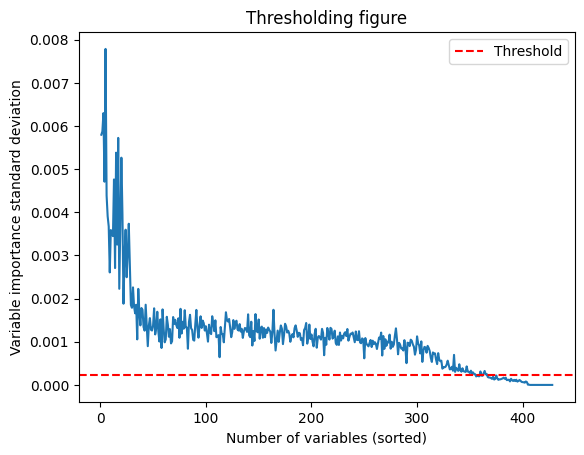

In [36]:
# visual representation of thresholding step
plt.plot(np.arange(1, len(sort_imp_sd) + 1), sort_imp_sd)
plt.axhline(y = threshold, linestyle = "--", color = "red", label = "Threshold")
plt.ylabel("Variable importance standard deviation")
plt.xlabel("Number of variables (sorted)")
plt.title("Thresholding figure")
plt.legend();


So the thresholding step cut 71 variables. This looks about right on the figure, given that the red line intersects with the blue line around 350 on the x axis (357 to be exact).

## 3.2 Interpretation

While GNT (2010) run 50 RFs per nested model, I do just 5 for the sake of time. This took about 30 minutes. It is important to do multiple runs per model in order to estimate the empirical standard deviation of the OOB errors for each model. If you recall from above, the empirical SD contributes to our final threshold.

If you understandably prefer not to wait, I've attached a cell which loads the aforementioned results from a NumPy file; you can skip running the RF cell and load the files in the following cell.



In [37]:
# initialize lists of oob errors
oob_errors_means = []
oob_errors_sds = []

In [38]:
# SKIP IF YOU DO NOT WANT TO WAIT, LOAD BELOW
# step 1: run stepwise RFs and record oob errors
for var in range(1, len(thresh_vars) + 1):
  temp_X = X[thresh_vars[:var]]
  oob_errors_var = []

  # 5 runs per nested model
  for run in range(5):
    model = RandomForestRegressor(n_estimators = 100, random_state = run,
                                  n_jobs = -1, oob_score = True)
    model.fit(temp_X, y)

    oob_error = 1 - model.oob_score_
    oob_errors_var.append(oob_error)

  oob_errors_means.append(np.mean(oob_errors_var))
  oob_errors_sds.append(np.std(oob_errors_var, ddof = 1))

In [ ]:
# RUN THIS IF YOU SKIPPED ABOVE
oob_errors_means = np.load("means.npy")
oob_errors_sds = np.load("sds.npy")

In [41]:
oob_errors_means = np.array(oob_errors_means)
oob_errors_sds   = np.array(oob_errors_sds)

In [42]:
# step 2: finding the "elbow" threshold
min_error_idx = np.argmin(oob_errors_means)
min_error = oob_errors_means[min_error_idx]
error_sd = oob_errors_sds[min_error_idx]

elbow = min_error + error_sd
print(f"Elbow threshold: {elbow}")

Elbow threshold: 0.5370251076123641


In [43]:
# step 3: variable selection
for var in range(len(oob_errors_means)):
    if oob_errors_means[var] <= elbow:
         keep_var = var
         break

optimal_num_vars = keep_var + 1
print(f"Optimal number of variables: {optimal_num_vars}")

Optimal number of variables: 13


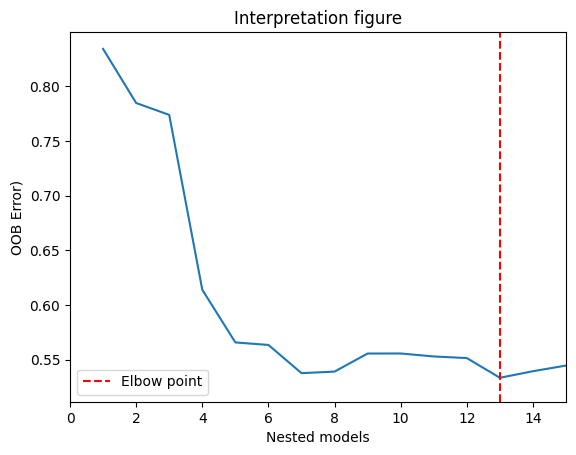

In [44]:
# visual representation of interpretation step
# where the elbow line first meets the blue line is the best model
plt.plot(np.arange(1, len(thresh_vars) + 1), oob_errors_means)
plt.axvline(x = optimal_num_vars, linestyle = "--", color = "red",
            label = "Elbow point")
plt.ylabel("OOB Error)")
plt.xlabel("Nested models")
plt.title("Interpretation figure")
plt.xlim(0, 15)
plt.legend();

The interpretation step left us with 13 variables. This looks right on the figure, given that the red line first intersects with the blue line at 13 on the x axis. Now, let's retrieve these variables.

In [45]:
# step 4: retrieve relevant variables and their importance values
i_vars = thresh_vars[:optimal_num_vars]
i_means = thresh_means[:optimal_num_vars]

i_df = pd.DataFrame({
    "variable": i_vars,
    "mean importance": i_means
}).sort_values(by = "mean importance", ascending = False)

print(i_df)

                        variable  mean importance
0          GDP_constantUSD_WDIpc         0.084884
1            HM_metals_income_PC         0.037451
2              HM_Coal_Income_PC         0.036394
3                   oilrents_WDI         0.031388
4             direct_tax_GDPGSRE         0.029421
5                  pop_total_WDI         0.025012
6                    GDPgrowthpc         0.023448
7   HM_Total_Resources_Income_PC         0.019230
8         GDP_currentlocal_WDIpc         0.015691
9        HM_Total_Fuel_Income_PC         0.015624
10           GDP_constantUSD_WDI         0.015308
11        HM_Total_Oil_Income_PC         0.014634
12                 total_non_tax         0.013797


## 3.3 Prediction

The prediction step seeks to find the most parsimonious model, based on the variables remaining from the interpretation step, that minimizes the net out-of-bag error. A sequential variable is only introduced if the error gain exceeds a threshold given by:

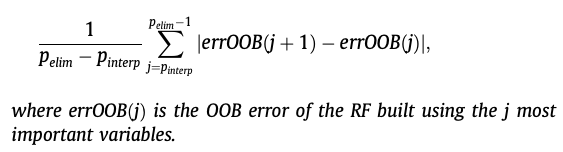

p_elim: the number of variables left after thresholding (in our case, 378)

p_interp: the number of variables left after interpretation (in our case, 15)

errOOB(j): OOB error of the RF built using the j most important variables

In [46]:
p_elim   = len(thresh_vars)
p_interp = optimal_num_vars

In [47]:
# prediction, step 1: find threshold
threshold_num = 0

for j in range(p_interp, p_elim):
    threshold_num += abs(oob_errors_means[j] - oob_errors_means[j-1])

threshold_pred = threshold_num / (p_elim - p_interp)

In [48]:
print(threshold_pred)

0.00688464229418804


In [49]:
current_num_vars = 1
current_oob_error = oob_errors_means[0]

In [50]:
# prediction, step 2: find best combination (minimum pred_oob_errors)
for j in range(1, p_elim):
    next_oob_error = oob_errors_means[j]
    improvement = current_oob_error - next_oob_error

    if improvement > threshold_pred:
        optimal_num_vars = j + 1
        current_oob_error = next_oob_error
    else:
        break

In [51]:
pred_vars = thresh_vars[:optimal_num_vars]

In [52]:
print("Number of prediction variables", len(pred_vars))
print("Prediction variables:", pred_vars)

Number of prediction variables 5
Prediction variables: ['GDP_constantUSD_WDIpc', 'HM_metals_income_PC', 'HM_Coal_Income_PC', 'oilrents_WDI', 'direct_tax_GDPGSRE']


The prediction step cuts the 13 variables from the interpretation step down to 5: GDP_constantUSD_WDIpc, HM_metals_income_PC, HM_Coal_Income_PC, oilrents_WDI, and direct_tax_GDPGSRE.

# 4. Final Model and Evaluation

We have our variables selected now, but we need to evaluate the model's performance.

In [53]:
X_pred = X[pred_vars]

In [54]:
# run a RF on our selected variables
final_rf = RandomForestRegressor(
    n_estimators = 500, random_state = 111, oob_score = True, n_jobs = -1)

final_rf.fit(X_pred, y)

final_oob_error = 1 - final_rf.oob_score_

In [55]:
print("OOB error", final_oob_error)

OOB error 0.5616230780180135


In [57]:
final_importances = final_rf.feature_importances_

final_df = pd.DataFrame({
    "variable": pred_vars,
    "importance": final_importances
}).sort_values(by = "importance", ascending = False)

print(final_df)

                variable  importance
4     direct_tax_GDPGSRE    0.278614
0  GDP_constantUSD_WDIpc    0.259101
3           oilrents_WDI    0.182337
2      HM_Coal_Income_PC    0.150004
1    HM_metals_income_PC    0.129943


In [58]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 111)
cv = cross_val_score(final_rf, X_pred, y, cv = kfold, scoring = "r2")

print(f"Average cross-validated R-squared: {cv.mean()}")

Average cross-validated R-squared: 0.3378304349343722


The cross-validated R-squared of 0.34 indicates that, on unseen data, the model predicts roughly 34% of the variance in v2x_polyarchy. Because this estimate is derived from cross-validation, it reflects the true predicted out-of-sample performance of our model.

# Conclusion

In order of variable importance, my final predictive model includes (1) direct tax as a share of GDP (direct_tax_GDPGSRE), (2) GDP per capita in constant 2005 US dollars (GDP_constantUSD_WDIpc), (3) share of oil gas rents as percentage of GDP (oilrents_WDI), (4) total coal income per capita in constant 2007 US dollars (HM_Coal_Income_PC), and (5) total income per capita from metal in constant 2007 US dollars (HM_metals_income_PC).

This model explains roughly 34% of the (out-of-sample) variation in the electoral democracy index (v2x_polyarchy). While this may seem low, this result meshes with what we might expect based on causal studies of the economic determinants of democracy. In almost all of these studies, unit and time fixed effects are included to eliminate time-invariant heterogeneity and unit-invariant shocks. The inherent endogeneity of economic and political institutions has been well-outlined (e.g. Przeworski, 2004), and even causal studies consider economic variables only a small portion of a larger endogenous puzzle explaining political outcomes. Predictive models make no efforts to address these nuances. But once one considers the countless omitted historical, cultural, and regional variables influencing democracy, this model performance seems quite reasonable.

A further extension of this project would opt to include non-economic predictors and would certainly check the robustness of Random Forests results against other predictive modeling and machine learning options.